In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import math
import os, sys
sys.path.append(os.path.relpath("./src"))
from kitaev_chain import kitaev_chain_model, quench_simulation, U
FFwriter=FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
from utils import intersections, to_n, s0, sx, sy, sz, maj_ordered, tensor_product, canon_eigen, expm, c, zero, LOSCHMIDT_BDG, LOSCHMIDT_TFIM, STATES

## Implementing the ghost sites method from this [article](https://arxiv.org/abs/2003.00095) 

In [2]:
def fermion_chain_from_spin_chain_params_parrallel_field(n_sites, J, h_z, h_edges_x):
    n = n_sites + 2
    mu = np.ones(n) * h_z; mu[0] = mu[-1] = 0
    t = np.ones(n - 1) * J; t[0] = t[-1] = h_edges_x
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, True)
def fermion_chain_from_spin_chain_params(n, J, h_z, h_edges_x):
    mu = np.ones(n) * h_z
    t = np.ones(n - 1) * J
    t *= .5
    delta = -t
    return kitaev_chain_model(n, mu, t, delta, False)


In [37]:
if False:
    n = 5
    res = 50
    J_range = np.linspace(0, 2, res)
    energies = np.zeros((2 * n, res))
    energies_2 = np.zeros((2 * (n - 2), res))
    for i, J in enumerate(J_range):
        H_ = fermion_chain_from_spin_chain_params(n - 2, 1, 1, J)
        H_2 = kitaev_chain_model(n - 2, 1, .5, -.5)
        evals, _ = np.linalg.eig(H_.bdg_hamiltonian())
        evals2, _ = np.linalg.eig(H_2.bdg_hamiltonian())
        energies[:, i] = sorted(evals)
        energies_2[:, i] = sorted(evals2)

    plt.plot(J_range, energies_2.T, 'b')
    plt.plot(J_range, energies.T, 'r')
    plt.title("Energies vs. h_x")
    plt.legend()

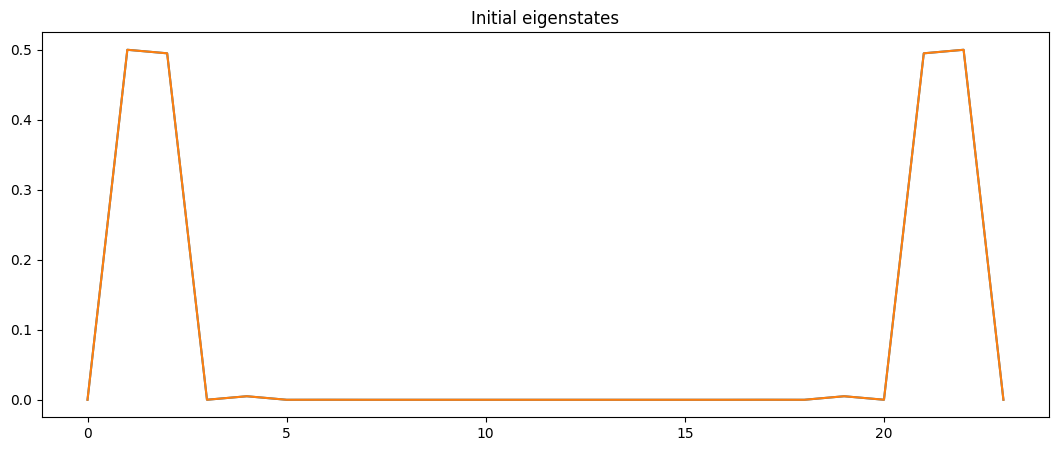

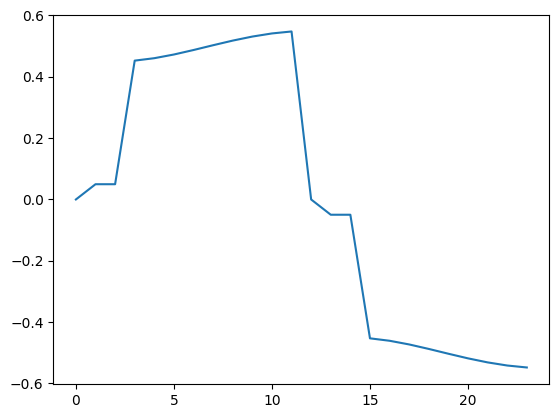

In [32]:
n_sites = 10
n = n_sites + 2
k = 1e-1
H0 = fermion_chain_from_spin_chain_params_parrallel_field(n_sites, 1, k, k)
H = fermion_chain_from_spin_chain_params_parrallel_field(n_sites, 1, 2, k)
sim = quench_simulation(H0, H, False)
sim.plot_initial_ground_states()
plt.show()
plt.plot(H0.bdg_evals_sorted)

### Test if $\eta_0 = \frac{1}{2} (c_0 + c_{0}^{\dagger}+c_{L+1} - c_{L+1}^{\dagger})$ is an eigenvector of H

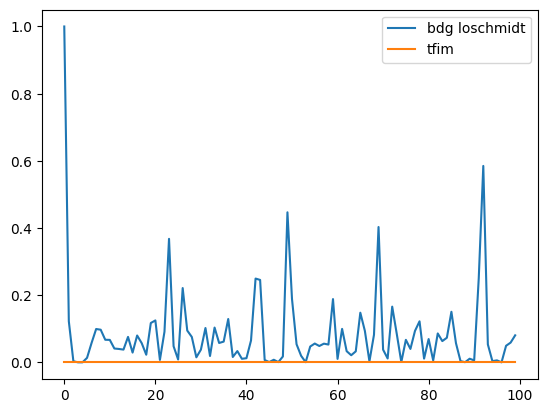

In [29]:
sim.fill_sim(1,100)
plt.plot(sim.simulation_data[LOSCHMIDT_BDG], label="bdg loschmidt")
plt.plot(sim.simulation_data[LOSCHMIDT_TFIM], label="tfim")
plt.legend()

In [40]:
H0.bdg_evals_sorted

array([-2.03511881e-17,  7.18384352e-02,  1.23414590e-01,  1.85024762e-01,
        2.49184230e-01,  3.13482802e-01,  3.76847383e-01,  4.38626208e-01,
        4.98334016e-01,  5.55566476e-01,  6.09967098e-01,  6.61213244e-01,
        7.09009983e-01,  7.53087464e-01,  7.93199975e-01,  8.29125841e-01,
        8.60667725e-01,  8.87653120e-01,  9.09934901e-01,  9.27391862e-01,
        9.39929194e-01,  9.47478883e-01, -7.77885242e-17, -7.18384352e-02,
       -1.23414590e-01, -1.85024762e-01, -2.49184230e-01, -3.13482802e-01,
       -3.76847383e-01, -4.38626208e-01, -4.98334016e-01, -5.55566476e-01,
       -6.09967098e-01, -6.61213244e-01, -7.09009983e-01, -7.53087464e-01,
       -7.93199975e-01, -8.29125841e-01, -8.60667725e-01, -8.87653120e-01,
       -9.09934901e-01, -9.27391862e-01, -9.39929194e-01, -9.47478883e-01])

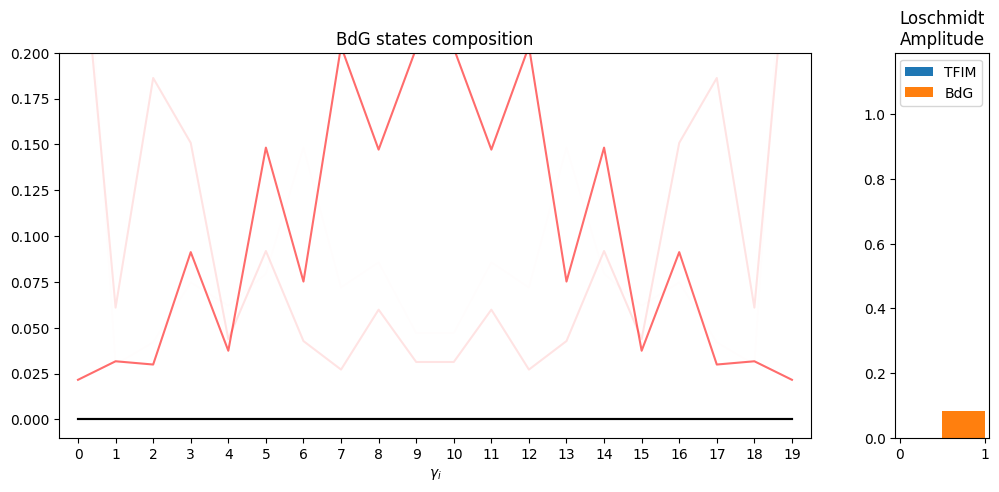

In [21]:
if True:
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [8, 1]})
    fig.set_size_inches((12, 5))
    plots = [None for _ in range(2 * n - 2)]

    ax1.set_title("BdG states composition")
    ax1.set_xlabel("$\\gamma_{i}$")
    ax1.set_xlim(-.5, 2 * (n - 2) - .5)
    ax1.set_xticks(range(2 * (n - 2)))
    ax1.set_ylim(-.01, .2)

    ax2.set_title("Loschmidt\nAmplitude")
    ax2.set_ylim(0,1.19)


    for i, (energy, state) in list(enumerate(zip(sim.H0.bdg_evals_sorted, sim.simulation_data[STATES][0].T)))[:-2]:
        plots[i] = ax1.plot(range(2 * (n - 2)), np.absolute(maj_ordered(state)[2:-2]) ** 2, color=(1 if energy > 1e-4 else 0, 0, 1 if energy < -1e-4 else 0, math.exp(-((energy * ( i ) ) * 1.5) ** 2)), label={f"{i} - {energy:.3f}"})[0]
    l_tfim = ax2.bar(0.25, sim.simulation_data[LOSCHMIDT_TFIM][0], 0.5, label='TFIM')
    l_bdg = ax2.bar(0.75, sim.simulation_data[LOSCHMIDT_BDG][0], 0.5, label='BdG')
    ax2.legend()

    def init(): return *plots, *l_tfim.patches, *l_bdg.patches

    def animate(frame):
        for i in range(2 * n - 2):
            plots[i].set_data(range(2 * (n - 2)), np.absolute(maj_ordered(sim.simulation_data[STATES][frame][:, i])[2:-2] ** 2))
        l_tfim.patches[0].set_height(sim.simulation_data[LOSCHMIDT_TFIM][frame])
        l_bdg.patches[0].set_height(sim.simulation_data[LOSCHMIDT_BDG][frame])
        return *plots, *l_tfim.patches, *l_bdg.patches

    anim = FuncAnimation(fig, animate,
                    frames = len(sim.simulation_data[LOSCHMIDT_TFIM]), interval = 30, blit = True)

    anim.save(f"simulations/quench1.mp4", writer=FFwriter)